ValueError: x and y must have same first dimension, but have shapes (120,) and (101,)

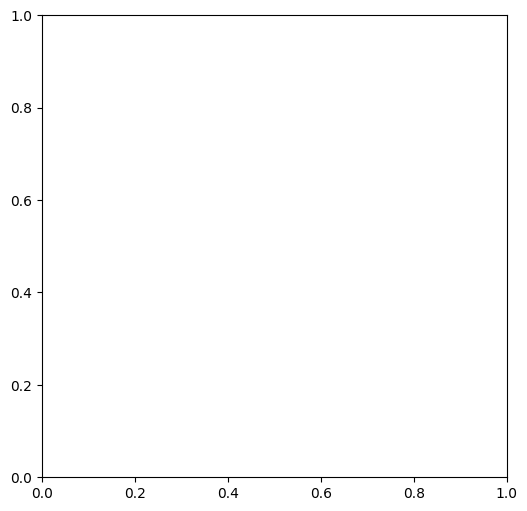

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# 参数设置
num_particles = 1000000
domain_size = 10.0  # cm
disc_radius = 3.0  # cm
temperature = 1000  # K
mass_electron = 9.10938356e-31  # kg
mass_ion = 1.6726219e-27  # kg (质子质量)
charge_electron = -1.60217662e-19  # C
charge_ion = 1.60217662e-19  # C
k_B = 1.38064852e-23  # J/K
num_steps = 1000
dt = 8e-10  # s (缩短时间步长)
epsilon_0 = 8.854187817e-12  # F/m (真空介电常数)

# 等效质量
effective_mass_electron = mass_electron * 1
effective_mass_ion = mass_ion * 1

# 计算粒子密度（m^-3）
volume = (2 * disc_radius / 100)**2  # 转换为m²
n = num_particles / volume  # 粒子密度

# 计算德拜长度
debye_length = np.sqrt(epsilon_0 * k_B * temperature / (n * charge_electron**2))

# 转换德拜长度到网格单元
grid_size = 120
cell_size = domain_size / grid_size  # cm
debye_radius_grid = int(np.ceil(debye_length / (cell_size / 100)))  # 转换为cm，再转换为网格单元

# 初始化粒子位置和速度
def initialize_positions_velocities(num_particles, disc_radius, mass, temperature):
    positions = np.random.uniform(-disc_radius, disc_radius, (num_particles, 2))
    velocities = np.random.normal(0, np.sqrt(k_B * temperature / mass) * 100, (num_particles, 2))  # m/s 转换为 cm/s
    distances = np.sqrt(np.sum(positions**2, axis=1))
    inside_disc = distances <= disc_radius
    return positions[inside_disc], velocities[inside_disc]

# 初始化电子和离子
electron_positions, electron_velocities = initialize_positions_velocities(num_particles, disc_radius, mass_electron, temperature)
ion_positions, ion_velocities = initialize_positions_velocities(num_particles, disc_radius, mass_ion, temperature)
num_particles_e = len(electron_positions)
num_particles_i = len(ion_positions)
charge_electron_array = np.full(num_particles_e, charge_electron)
charge_ion_array = np.full(num_particles_i, charge_ion)
mass_electron_array = np.full(num_particles_e, effective_mass_electron)
mass_ion_array = np.full(num_particles_i, effective_mass_ion)

# 电势和电场初始化
phi = np.zeros((grid_size, grid_size))
electric_field = np.zeros((grid_size, grid_size, 2))

# 泊松方程求解
@njit
def solve_poisson(phi, rho, num_iterations=100):
    for _ in range(num_iterations):
        phi_new = np.copy(phi)
        phi_new[1:-1, 1:-1] = (
            phi[2:, 1:-1] + phi[:-2, 1:-1] +
            phi[1:-1, 2:] + phi[1:-1, :-2] -
            rho[1:-1, 1:-1] * cell_size**2
        ) / 4.0
        phi = phi_new
    return phi

# 计算电场
@njit
def compute_electric_field(phi, cell_size):
    ex = (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2 * cell_size)
    ey = (phi[1:-1, 2:] - phi[1:-1, :-2]) / (2 * cell_size)
    return ex, ey

# 计算电荷密度
def compute_charge_density(positions, charge, grid_size, domain_size, cell_size):
    rho = np.zeros((grid_size, grid_size))
    bin_edges = [np.linspace(-domain_size / 2, domain_size / 2, grid_size + 1)] * 2
    hist, _, _ = np.histogram2d(positions[:, 0], positions[:, 1], bins=bin_edges, range=[[-domain_size / 2, domain_size / 2], [-domain_size / 2, domain_size / 2]])
    rho = hist * charge
    return rho

# 计算电场加速度
def compute_acceleration(positions, electric_field, domain_size, cell_size, charge, mass):
    grid_positions = np.floor((positions + domain_size / 2) / cell_size).astype(int)
    grid_positions = np.clip(grid_positions, 0, grid_size - 1)
    accelerations = np.zeros_like(positions)
    for i in range(len(positions)):
        ex = electric_field[grid_positions[i, 0], grid_positions[i, 1], 0]
        ey = electric_field[grid_positions[i, 0], grid_positions[i, 1], 1]
        accelerations[i] = (charge / mass) * np.array([ex, ey])
    return accelerations

# 更新粒子位置和速度（使用Verlet方法）
def verlet_update(positions, velocities, accelerations, new_accelerations, dt, domain_size):
    new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
    new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt

    # 确保粒子不会离开方格边界
    for i in range(len(new_positions)):
        for j in range(2):
            if new_positions[i, j] < -domain_size / 2 or new_positions[i, j] > domain_size / 2:
                new_velocities[i, j] *= -1  # 反弹速度
                new_positions[i, j] = positions[i, j]  # 保持位置不变

    return new_positions, new_velocities

# 初始化电荷密度
rho_e = compute_charge_density(electron_positions, charge_electron, grid_size, domain_size, cell_size)
rho_i = compute_charge_density(ion_positions, charge_ion, grid_size, domain_size, cell_size)
rho = rho_e + rho_i

# 求解初始电势
phi = solve_poisson(phi, rho)

# 计算初始电场
ex, ey = compute_electric_field(phi, cell_size)
ex = np.pad(ex, ((1, 1), (1, 1)), mode='constant', constant_values=0)
ey = np.pad(ey, ((1, 1), (1, 1)), mode='constant', constant_values=0)
electric_field[:, :, 0] = ex
electric_field[:, :, 1] = ey

# 用于存储中线电子密度
midline_electron_density = []

# 模拟
for step in range(num_steps + 1):  # 包括初始状态
    if step > 0:
        # 计算电子和离子的加速度
        electron_acceleration = compute_acceleration(electron_positions, electric_field, domain_size, cell_size, charge_electron, effective_mass_electron)
        ion_acceleration = compute_acceleration(ion_positions, electric_field, domain_size, cell_size, charge_ion, effective_mass_ion)

        # 更新电子位置和速度
        electron_positions, electron_velocities = verlet_update(electron_positions, electron_velocities, electron_acceleration, electron_acceleration, dt, domain_size)

        # 更新离子位置和速度
        ion_positions, ion_velocities = verlet_update(ion_positions, ion_velocities, ion_acceleration, ion_acceleration, dt, domain_size)

        # 计算新的电荷密度
        rho_e = compute_charge_density(electron_positions, charge_electron, grid_size, domain_size, cell_size)
        rho_i = compute_charge_density(ion_positions, charge_ion, grid_size, domain_size, cell_size)
        rho = rho_e + rho_i

        # 解决泊松方程
        phi = solve_poisson(phi, rho)

        # 计算电场
        ex, ey = compute_electric_field(phi, cell_size)
        ex = np.pad(ex, ((1, 1), (1, 1)), mode='constant', constant_values=0)
        ey = np.pad(ey, ((1, 1), (1, 1)), mode='constant', constant_values=0)
        electric_field[:, :, 0] = ex
        electric_field[:, :, 1] = ey

    # 可视化
    if step % 10 == 0:
        fig1, ax1 = plt.subplots(figsize=(6, 6))
        hist_i, xedges, yedges = np.histogram2d(ion_positions[:, 0], ion_positions[:, 1], bins=grid_size, range=[[-domain_size / 2, domain_size / 2], [-domain_size / 2, domain_size / 2]])
        im1 = ax1.imshow(np.abs(hist_i.T), extent=[-domain_size / 2, domain_size / 2, -domain_size / 2, domain_size / 2], origin='lower', cmap='plasma')
        fig1.colorbar(im1, ax=ax1, label='ion density')
        ax1.set_title(f'ion_positions (step {step})')
        fig1.savefig(f'ion_positions_step_{step}.png')
        plt.close(fig1)

        fig2, ax2 = plt.subplots(figsize=(6, 6))
        hist_e, xedges, yedges = np.histogram2d(electron_positions[:, 0], electron_positions[:, 1], bins=grid_size, range=[[-domain_size / 2, domain_size / 2], [-domain_size / 2, domain_size / 2]])
        im2 = ax2.imshow(np.abs(hist_e.T), extent=[-domain_size / 2, domain_size / 2, -domain_size / 2, domain_size / 2], origin='lower', cmap='plasma')
        fig2.colorbar(im2, ax=ax2, label='electron density')
        ax2.set_title(f'electron_positions (step {step})')
        fig2.savefig(f'electron_positions_step_{step}.png')
        plt.close(fig2)

        fig3, ax3 = plt.subplots(figsize=(6, 6))
        efield_magnitude = np.sqrt(electric_field[:, :, 0]**2 + electric_field[:, :, 1]**2)
        im3 = ax3.imshow(efield_magnitude, extent=[-domain_size / 2, domain_size / 2, -domain_size / 2, domain_size / 2], origin='lower', cmap='plasma')
        fig3.colorbar(im3, ax=ax3, label='electric field (V/m)')
        ax3.set_title(f'electric_field (step {step})')
        fig3.savefig(f'electric_field_step_{step}.png')
        plt.close(fig3)

        fig4, ax4 = plt.subplots(figsize=(6, 6))
        im4 = ax4.imshow(np.abs(hist_e.T), extent=[-domain_size / 2, domain_size / 2, -domain_size / 2, domain_size / 2], origin='lower', cmap='plasma')
        fig4.colorbar(im4, ax=ax4, label='electron density')
        ax4.set_title(f'electron_density (step {step})')
        fig4.savefig(f'electron_density_step_{step}.png')
        plt.close(fig4)

        midline_density, _ = np.histogram(electron_positions[:, 0], bins=grid_size, range=[-domain_size / 2, domain_size / 2])
        midline_electron_density.append(midline_density)

        # 绘制中线电子密度图
        midline_electron_density_array = np.array(midline_electron_density).T
        fig5, ax5 = plt.subplots(figsize=(6, 6))
        for i, density in enumerate(midline_electron_density_array):
            if i % (num_steps // 10) == 0:  # 每10%的步骤绘制一次
                ax5.plot(np.linspace(-domain_size / 2, domain_size / 2, grid_size), density, label=f'Step {i * (num_steps // 10)}')
        ax5.set_xlabel('position(cm)')
        ax5.set_ylabel('electron_density')
        ax5.legend()
        fig5.savefig(f'midline_electron_density_step_{step}.png')
        plt.close(fig5)
